In [6]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torchvision import transforms

In [7]:
dataset_mean = [0.57121, 0.57445, 0.60535]
dataset_std = [0.11756, 0.12333, 0.11987]

In [8]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=12, num_channels=3):
        super(TrafficSignCNN, self).__init__()
        
        self.conv0 = nn.Conv2d(in_channels=num_channels, out_channels=3, kernel_size=1, padding=0)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.5)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(0.5)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        
        self.pool6 = nn.MaxPool2d(2, 2)
        self.dropout6 = nn.Dropout(0.5)

        self.flattened_size = 8192 + 4096 + 2048
        
        self.fc1 = nn.Linear(self.flattened_size, 1024)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout_fc2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        # print(f"Input shape: {x.shape}") if self.training else None
        
        x0 = F.relu(self.conv0(x))
        x1 = F.relu(self.conv1(x0))
        x2 = F.relu(self.conv2(x1))
        
        x2_pool = self.pool2(x2)
        x2_drop = self.dropout2(x2_pool)
        
        x3 = F.relu(self.conv3(x2_drop))
        x4 = F.relu(self.conv4(x3))
        
        x4_pool = self.pool4(x4)
        x4_drop = self.dropout4(x4_pool)
        
        x5 = F.relu(self.conv5(x4_drop))
        x6 = F.relu(self.conv6(x5))
        
        x6_pool = self.pool6(x6)
        x6_drop = self.dropout6(x6_pool)
        
        x2_flat = x2_drop.view(x2_drop.size(0), -1)
        x4_flat = x4_drop.view(x4_drop.size(0), -1)
        x6_flat = x6_drop.view(x6_drop.size(0), -1)
        
        x_concat = torch.cat((x2_flat, x4_flat, x6_flat), dim=1)
        
        fc1 = F.relu(self.fc1(x_concat))
        fc1_drop = self.dropout_fc1(fc1)
        fc2 = F.relu(self.fc2(fc1_drop))
        fc2_drop = self.dropout_fc2(fc2)
        logits = self.fc3(fc2_drop)
        
        return logits

In [ ]:
# def live_test_video(model_path):
#     # Load model
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = TrafficSignCNN(num_classes=12).to(device)
#     model.load_state_dict(torch.load(model_path, map_location=device))
#     model.eval()
    
#     # Transformations (must match training)
#     transform = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((32, 32)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=dataset_mean, std=dataset_std)
#     ])
    
#     cap = cv2.VideoCapture(0)
#     if not cap.isOpened():
#         print("Error: Could not open webcam")
#         return
    
#     try:
#         while True:
#             ret, frame = cap.read()
#             if not ret:
#                 print("Error: Couldn't read frame")
#                 break
                
#             # Process frame
#             rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             tensor_img = transform(rgb).unsqueeze(0).to(device)
            
#             # Inference
#             with torch.no_grad():
#                 outputs = model(tensor_img)
#                 _, pred = torch.max(outputs, 1)
#                 sign_name = class_names[pred.item()]
            
#             # Display option 1: Save to file (works everywhere)
#             output_frame = frame.copy()
#             cv2.putText(output_frame, sign_name, (10, 30),
#                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
#             cv2.imwrite('latest_detection.jpg', output_frame)
            
#             # Display option 2: For Jupyter notebooks
#             try:
#                 from IPython.display import Image, clear_output, display
#                 _, buffer = cv2.imencode('.jpg', output_frame)
#                 display(Image(data=buffer.tobytes()))
#                 clear_output(wait=True)
#             except ImportError:
#                 pass
            
#             # Exit condition (no need for waitKey)
#             # Press 'q' in terminal/notebook to stop
#             # Or implement your own stopping condition
            
#     except KeyboardInterrupt:
#         print("Stopping...")
#     finally:
#         cap.release()
#         print("Webcam released")

In [ ]:
# live_test_video("best_model.pth")

In [ ]:
def live_test_image(model_path, test_path):
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TrafficSignCNN(num_classes=12)
    model.load_state_dict(torch.load(model_path, map_location=device,
        weights_only=True, mmap=True if device == 'cpu' else False))
    model.eval()
    model.to(device)
    
    # Define transforms
    transform_simple = A.Compose(
    [
        A.Resize(32, 32),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ],
    p=1
)
    
    # Class names
    class_names = [
        'barred_area',
        'cross_walk',
        'go_straight',
        'no_passing_zone_beginning',
        'parking_zone',
        'priority_over',
        'steep_hill_downhill',
        'steep_hill_uphill',
        'stop',
        'tunnel_beginning',
        'turn_left',
        'turn_right'
]
    
    # Get image paths
    if os.path.isdir(test_path):
        image_paths = [os.path.join(test_path, f) for f in os.listdir(test_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    elif os.path.isfile(test_path):
        image_paths = [test_path]
    else:
        raise ValueError(f"Path {test_path} does not exist")
    
    if not image_paths:
        print("No images found to process")
        return
    
    # Process all images
    predictions = []
    for img_path in image_paths:
        image = cv2.imread(img_path)
        if image is None:
            print(f"Could not read {img_path}")
            continue
            
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        transformed = transform_simple(image=rgb)
        input_tensor = transformed["image"].unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            _, pred = torch.max(outputs, 1)
            confidence = torch.nn.functional.softmax(outputs, dim=1)[0][pred].item()
            
        predictions.append({
            'path': img_path,
            'image': rgb,
            'class_idx': pred.item(),
            'confidence': confidence
        })
    
    # Display results
    plot_predictions(predictions, class_names)

def plot_predictions(predictions, class_names, cols=4):
    plt.figure(figsize=(20, 10))
    rows = (len(predictions) + cols - 1) // cols
    
    for i, pred in enumerate(predictions, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(pred['image'])
        plt.title(f"{class_names[pred['class_idx']]}\n({pred['confidence']:.1%})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

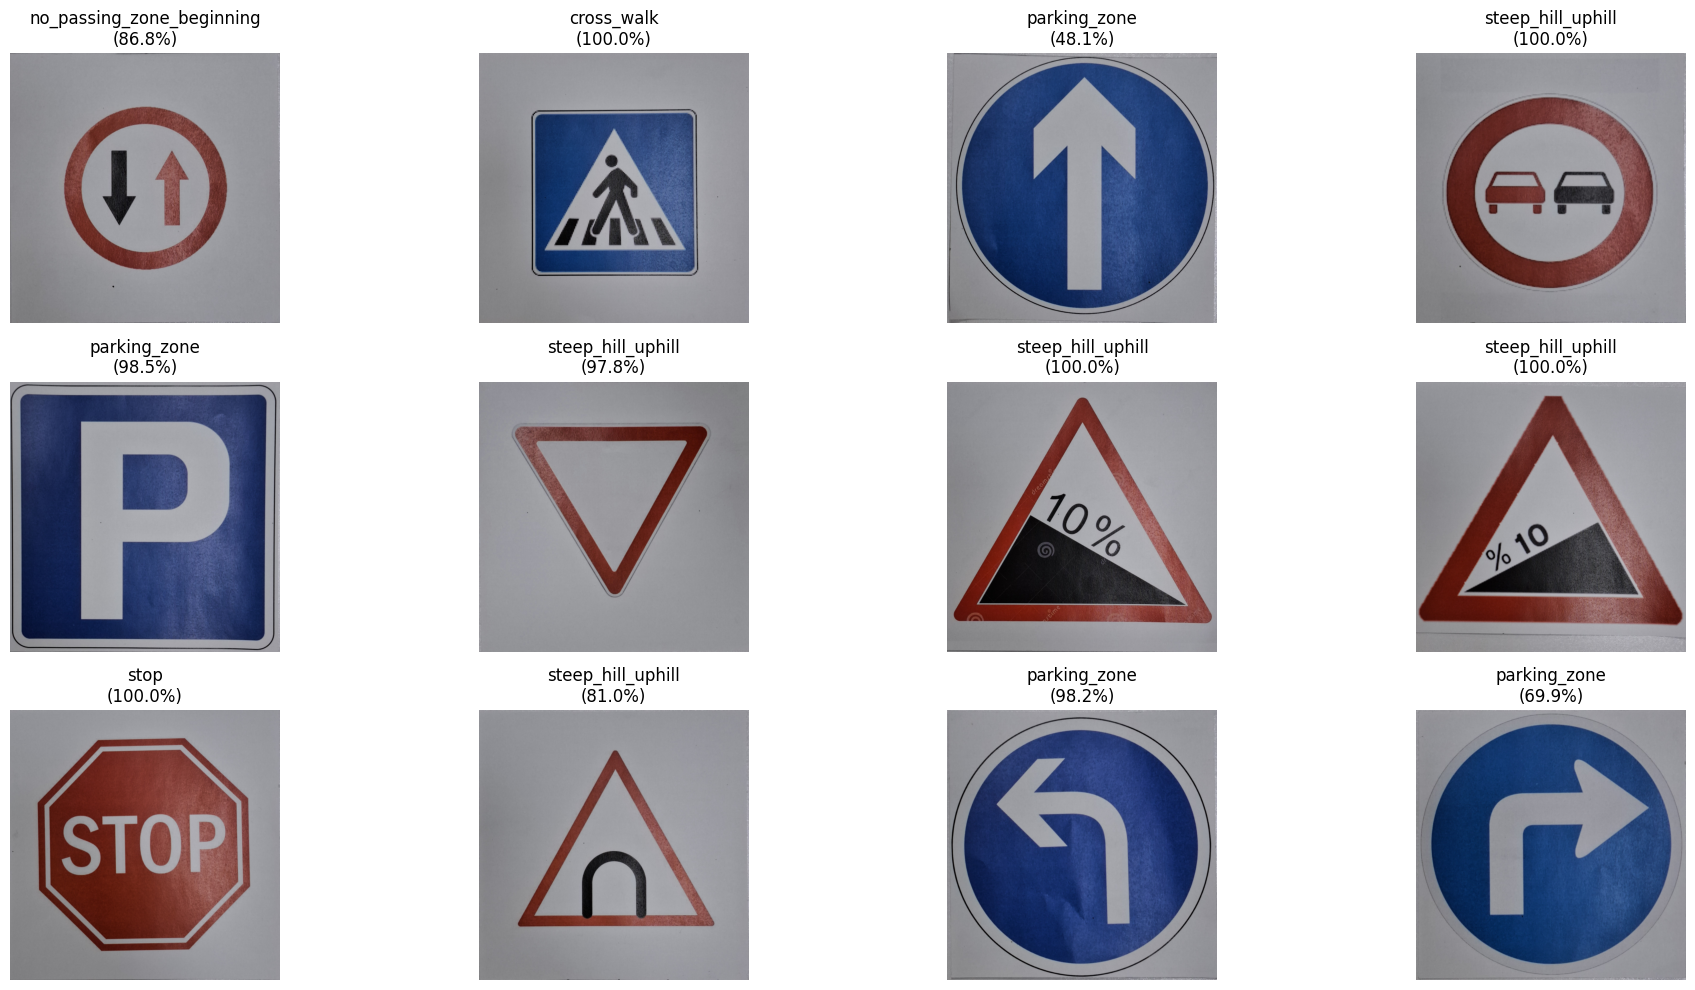

In [12]:
model_path = "Models/traffic_sign_cnn_V01_C.pth"
test_path = "test"

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

live_test_image(model_path, test_path)